# 植物幼苗分类

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-获取数据" data-toc-modified-id="1.-获取数据-1">1. 获取数据</a></span></li><li><span><a href="#2.-清洗数据" data-toc-modified-id="2.-清洗数据-2">2. 清洗数据</a></span><ul class="toc-item"><li><span><a href="#2.1-掩蔽绿色植物" data-toc-modified-id="2.1-掩蔽绿色植物-2.1">2.1 掩蔽绿色植物</a></span></li><li><span><a href="#2.2-特征归一化" data-toc-modified-id="2.2-特征归一化-2.2">2.2 特征归一化</a></span></li><li><span><a href="#2.3-标签类别" data-toc-modified-id="2.3-标签类别-2.3">2.3 标签类别</a></span></li></ul></li><li><span><a href="#3.-模型" data-toc-modified-id="3.-模型-3">3. 模型</a></span><ul class="toc-item"><li><span><a href="#3.1-划分数据集" data-toc-modified-id="3.1-划分数据集-3.1">3.1 划分数据集</a></span></li><li><span><a href="#3.2-数据生成" data-toc-modified-id="3.2-数据生成-3.2">3.2 数据生成</a></span></li><li><span><a href="#3.3-建立模型" data-toc-modified-id="3.3-建立模型-3.3">3.3 建立模型</a></span></li><li><span><a href="#3.4-训练模型" data-toc-modified-id="3.4-训练模型-3.4">3.4 训练模型</a></span></li><li><span><a href="#3.5--loss-acc-曲线" data-toc-modified-id="3.5--loss-acc-曲线-3.5">3.5  loss acc 曲线</a></span></li></ul></li><li><span><a href="#4.-评估模型" data-toc-modified-id="4.-评估模型-4">4. 评估模型</a></span><ul class="toc-item"><li><span><a href="#4.1-Score-&amp;-Acc" data-toc-modified-id="4.1-Score-&amp;-Acc-4.1">4.1 Score &amp; Acc</a></span></li><li><span><a href="#4.2-混淆矩阵" data-toc-modified-id="4.2-混淆矩阵-4.2">4.2 混淆矩阵</a></span></li></ul></li><li><span><a href="#5.-本地模型预测" data-toc-modified-id="5.-本地模型预测-5">5. 本地模型预测</a></span><ul class="toc-item"><li><span><a href="#5.1-加载本地模型" data-toc-modified-id="5.1-加载本地模型-5.1">5.1 加载本地模型</a></span></li><li><span><a href="#5.2-预测" data-toc-modified-id="5.2-预测-5.2">5.2 预测</a></span></li></ul></li><li><span><a href="#6.-可视化卷积中间层的图像" data-toc-modified-id="6.-可视化卷积中间层的图像-6">6. 可视化卷积中间层的图像</a></span><ul class="toc-item"><li><span><a href="#6.1-例化一个模型用于返回各层激活输出" data-toc-modified-id="6.1-例化一个模型用于返回各层激活输出-6.1">6.1 例化一个模型用于返回各层激活输出</a></span></li><li><span><a href="#6.2-各层各通道汇总可视化" data-toc-modified-id="6.2-各层各通道汇总可视化-6.2">6.2 各层各通道汇总可视化</a></span></li></ul></li><li><span><a href="#7.-PyQt实现的图形化界面" data-toc-modified-id="7.-PyQt实现的图形化界面-7">7. PyQt实现的图形化界面</a></span></li></ul></div>

## 1. 获取数据

获取图像并调整到70 x 70 px，更快地训练模型  
从文件夹名称获得图像标签

In [1]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

ScaleTo = 70  # 缩放到70px
seed = 7  # 固定随机数种子

path = './train/*/*.png' 
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# 获取图片并调整大小、标签
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  
    trainLabel.append(img.split('\\')[-2])  # 获取标签(文件夹名)
    j += 1

trainImg = np.asarray(trainImg)  # 训练图片集
trainLabel = pd.DataFrame(trainLabel)  # 训练标签集

植物幼苗图片样本

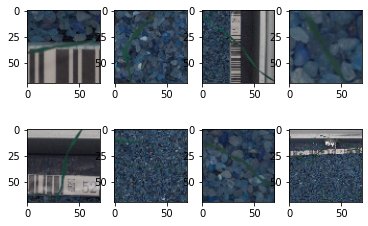

In [2]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

可见，每张植物幼苗的照片都有一个背景，去除背景有助于实现更好的模型精度。

## 2. 清洗数据

为了去除背景，假定照片上所有的植物都是绿色的。可以创建一个蒙版，将留下一些绿色的范围，并删除图像的其他部分。

### 2.1 掩蔽绿色植物

为了创建去除背景的遮罩，需要将RGB图像转换为HSV。HSV是RGB颜色模型的替代品。在HSV中更容易表示一个色彩范围。

除此之外，首先对图像进行模糊处理以去除噪音。  
在创建HSV图像后，选择的绿色范围创建蒙版，将其转换为布尔蒙版并应用于原始图像。

* 使用高斯模糊去除噪音
* 将颜色转换为HSV
* 创建遮罩
* 创建布尔蒙版
* 应用布尔蒙版，得到无背景的图像

In [3]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # 使用高斯模糊
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # 转换为HSV图像
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # 创建遮罩 (参数 - 绿色颜色范围)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 创建布尔蒙版
    bMask = mask > 0  
    
    # 应用布尔蒙版
    clear = np.zeros_like(img, np.uint8)  
    clear[bMask] = img[bMask]  
    
    clearTrainImg.append(clear)  

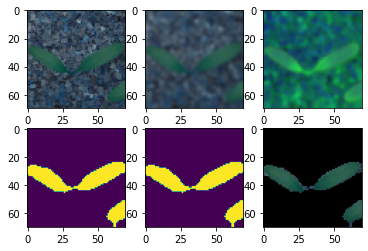

In [4]:
# 图像样本处理各阶段
if getEx:
    plt.subplot(2, 3, 1); plt.imshow(img)  # 原始图像
    plt.subplot(2, 3, 2); plt.imshow(blurImg)  # 模糊图像
    plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV图像
    plt.subplot(2, 3, 4); plt.imshow(mask)  # 遮罩
    plt.subplot(2, 3, 5); plt.imshow(bMask)  # 布尔遮罩
    plt.subplot(2, 3, 6); plt.imshow(clear)  # 无背景图像
    getEx = False

clearTrainImg = np.asarray(clearTrainImg)

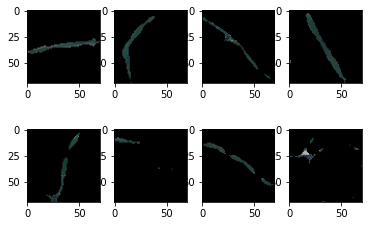

In [5]:
# 处理后图像的其他例子
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

可见，去除了大部分背景

### 2.2 特征归一化

将输入值从[0 ... 255]设置为[0 ... 1]

In [6]:
clearTrainImg = clearTrainImg / 255

### 2.3 标签类别

标签是12个字符串名称，创建具有此名称的类，比如 ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat' 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed' 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']，并按照此数组中的位置编码每个标签。  
例如“ charlock' - > [0，1，0，0，0，0，0，0，0，0，0，0，0，0，0]。

In [7]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode标签并创建类别
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# 使标签分类化
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


In [8]:
clearTrainLabel

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

不同类别植物幼苗的数量

Text(0.5, 1.0, 'Number of different type of seedlings')

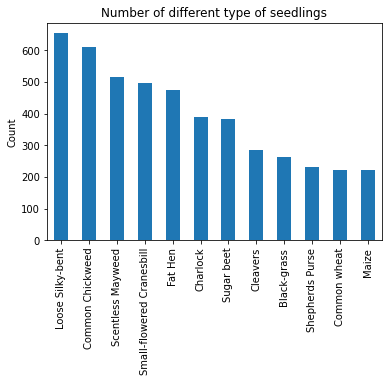

In [9]:
trainLabel[0].value_counts().plot(kind='bar')
plt.ylabel("Count")
plt.title("Number of different type of seedlings")

从上面的条形图中可以看出，最大数量的图像属于Loose Silky-bent类。有5个类别的图像数量非常少，2个类别的图像数量很多，其余的在中位数附近，数据类别不平衡。

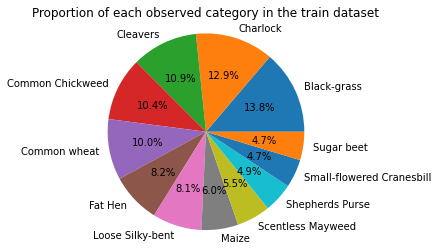

In [10]:
plt.pie(trainLabel[0].value_counts(),
       explode=(0,0,0,0,0,0,0,0,0,0,0,0),
       labels = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"],
       autopct = "%1.1f%%")
plt.axis('equal')
plt.title("Proportion of each observed category in the train dataset")
plt.show()

## 3. 模型

### 3.1 划分数据集

In [11]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, 
                                                random_state=seed, 
                                                stratify = clearTrainLabel #分层抽样
                                                )

### 3.2 数据生成

为了避免过拟合，创建图像生成器，在模型拟合过程中，图像生成器会随机旋转、缩放、移位和翻转图像。

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # 在范围内随机旋转图像
        zoom_range = 0.1, # 随机缩放图像 
        width_shift_range=0.1,  # 随机水平平移图像
        height_shift_range=0.1,  # 随机垂直平移图像 
        horizontal_flip=True,  # 随机水平翻转图像
        vertical_flip=True  # 随机垂直翻转图像
    )  
datagen.fit(trainX)

### 3.3 建立模型

有六个卷积层，最后三个全连接层。前两个卷积层有64个过滤器，接下来是128个过滤器，最后两个层有256个过滤器。在每一对卷积层之后，模型都有最大池化层。 

另外，为了减少每对卷积层之后的过拟合，使用dropout层（卷积层之间10%，全连接层之间50%），在每层之间使用了批量标准化层。

最后，使用了三个全连接层进行分类。在最后一层，神经网络输出12个类别中每个类别的概率分布。

In [13]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed)  

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 66, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 66, 66, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                                 
                                                        

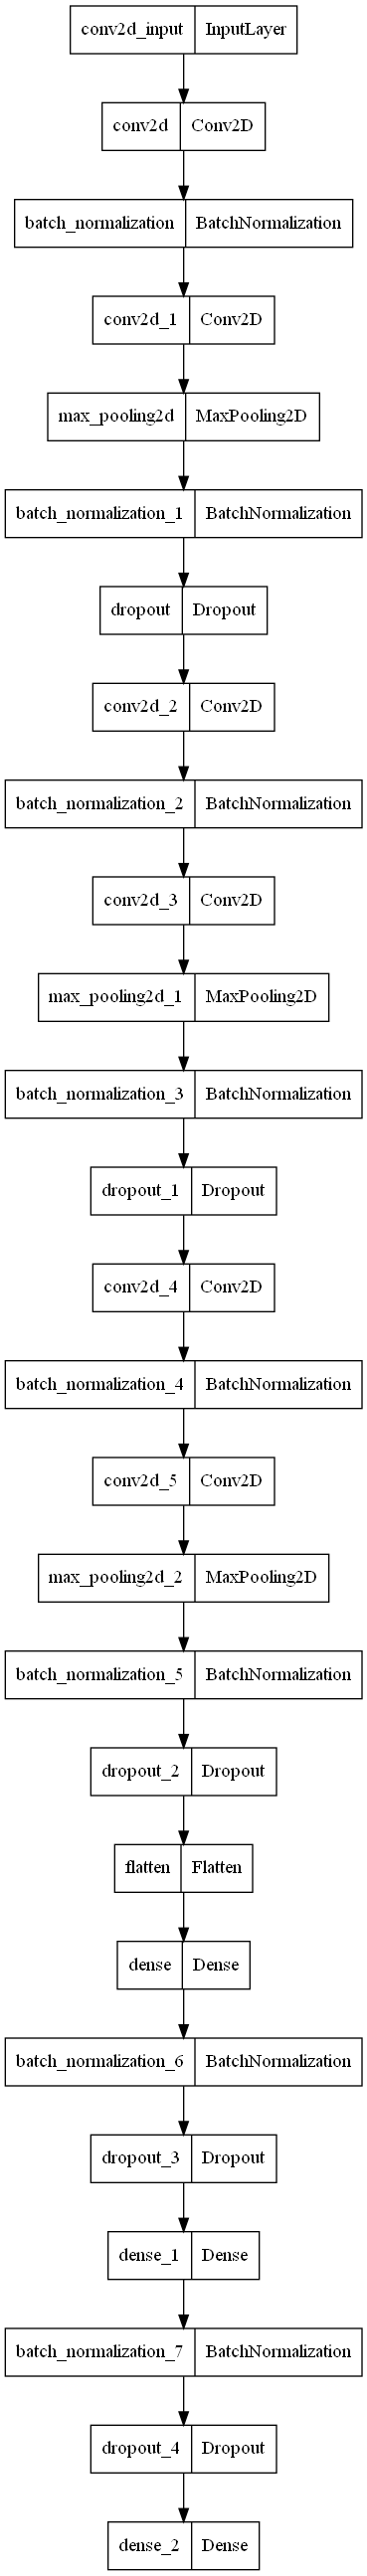

In [33]:
from keras import utils
utils.plot_model(model)

### 3.4 训练模型

In [14]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

# 当评价指标不再提升时，减少学习率
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# all callbacks
callbacks_list = [early_stopping, learning_rate_reduction]

# fit model
history = model.fit(datagen.flow(trainX, trainY, batch_size=8), 
                           epochs=40, validation_data=(testX, testY), 
                        #    steps_per_epoch=trainX.shape[0], 
                           callbacks=callbacks_list)

Epoch 1/40
535/535 [==============================] - 287s 531ms/step - loss: 2.7750 - accuracy: 0.2084 - val_loss: 3.1471 - val_accuracy: 0.1621 - lr: 0.0010
Epoch 2/40
535/535 [==============================] - 285s 534ms/step - loss: 2.1212 - accuracy: 0.3076 - val_loss: 1.5287 - val_accuracy: 0.4695 - lr: 0.0010
Epoch 3/40
535/535 [==============================] - 294s 550ms/step - loss: 1.9054 - accuracy: 0.3630 - val_loss: 1.5990 - val_accuracy: 0.4442 - lr: 0.0010
Epoch 4/40
535/535 [==============================] - 283s 528ms/step - loss: 1.7771 - accuracy: 0.3939 - val_loss: 1.5087 - val_accuracy: 0.4358 - lr: 0.0010
Epoch 5/40
535/535 [==============================] - ETA: 0s - loss: 1.6770 - accuracy: 0.4250
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
535/535 [==============================] - 283s 529ms/step - loss: 1.6770 - accuracy: 0.4250 - val_loss: 1.9655 - val_accuracy: 0.4295 - lr: 0.0010
Epoch 6/40
535/535 [========================

In [19]:
# 保存模型
model.save("model.h5")

### 3.5  loss acc 曲线

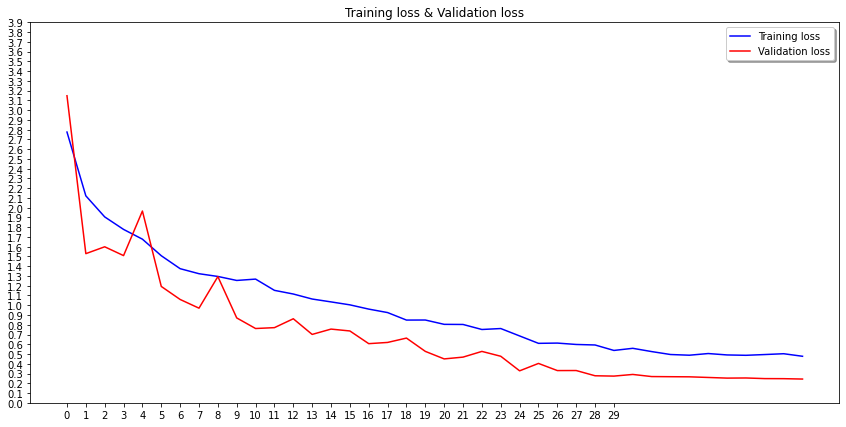

In [15]:
plt.figure(figsize=(14.5, 7))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.xticks(np.arange(0, 30, 1))
plt.yticks(np.arange(0, 4, 0.1))
plt.legend(loc='best', shadow=True)
plt.title("Training loss & Validation loss")

plt.show()

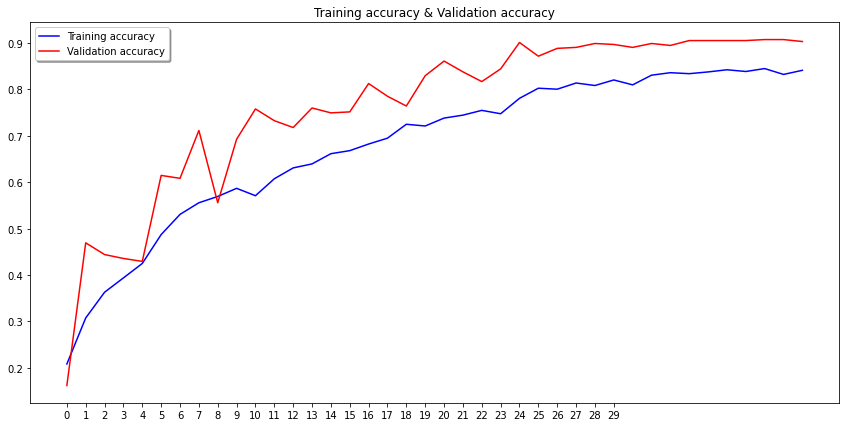

In [16]:
plt.figure(figsize=(14.5, 7))

plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, 30, 1))

plt.legend(loc='best', shadow=True)
plt.title("Training accuracy & Validation accuracy")

plt.show()

## 4. 评估模型

### 4.1 Score & Acc

In [17]:
#Final score and accuracy of the model
# trainX, testX, trainY, testY
score, acc = model.evaluate(testX,testY)
score1, acc1 = model.evaluate(trainX,trainY)
print('Validation score:', score,'   Validation accuracy:', acc)
print('Train score:', score1,'   Train accuracy:',acc1)

134/134 [==============================] - 62s 465ms/step - loss: 0.2365 - accuracy: 0.9123
Validation score: 0.243414968252182    Validation accuracy: 0.9031578898429871
Train score: 0.2364691197872162    Train accuracy: 0.9122806787490845


### 4.2 混淆矩阵

15/15 [==============================] - 8s 475ms/step


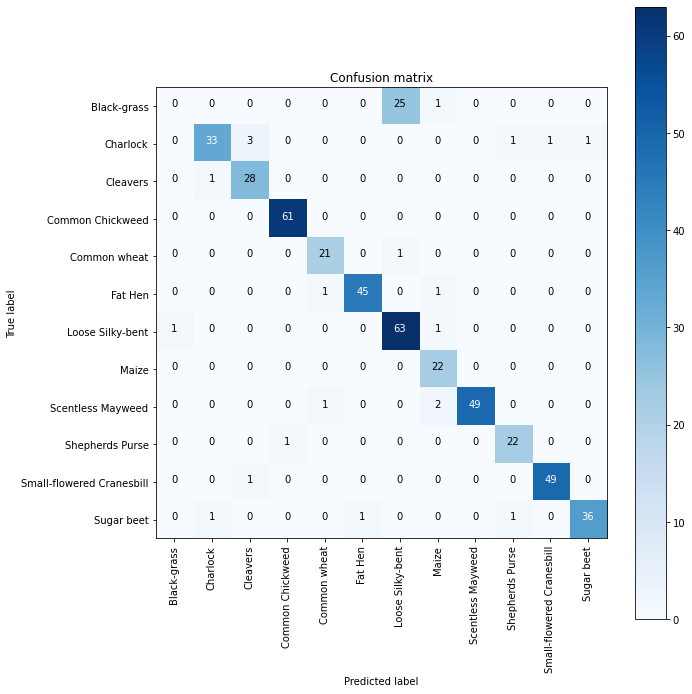

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

confusionMTX = confusion_matrix(trueY, predYClasses) 

plot_confusion_matrix(confusionMTX, classes = le.classes_) 

## 5. 本地模型预测

### 5.1 加载本地模型

In [20]:
from keras.models import load_model
loaded_model = load_model('./model.h5')

In [21]:
score, acc = loaded_model.evaluate(testX,testY)
score1, acc1 = loaded_model.evaluate(trainX,trainY)
print('Validation score:', score,'   Validation accuracy:', acc)
print('Train score:', score1,'   Train accuracy:',acc1)

134/134 [==============================] - 70s 525ms/step - loss: 0.2365 - accuracy: 0.9123
Validation score: 0.243414968252182    Validation accuracy: 0.9031578898429871
Train score: 0.2364691197872162    Train accuracy: 0.9122806787490845


### 5.2 预测

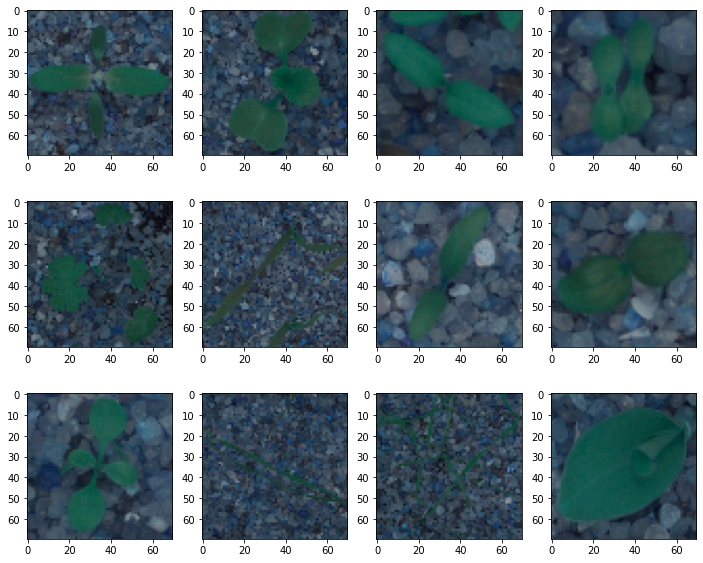

In [22]:
path = './MyTest/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('\\')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

plt.figure(figsize=(12, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(testImg[i])

选取的12张预测样本

In [23]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    bMask = mask > 0  
    
    clear = np.zeros_like(img, np.uint8) 
    clear[bMask] = img[bMask]  
    
    clearTestImg.append(clear)  

clearTestImg = np.asarray(clearTestImg)

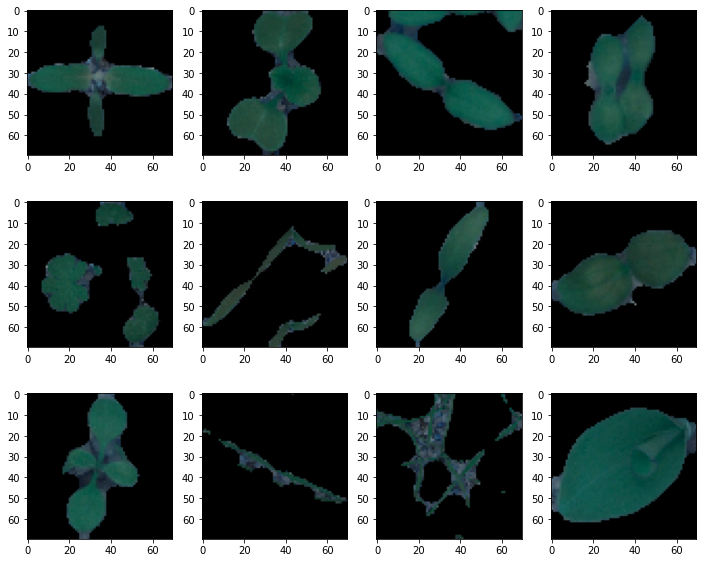

In [24]:
plt.figure(figsize=(12, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(clearTestImg[i])

图像处理后的样本

In [25]:
clearTestImg = clearTestImg / 255

In [26]:
pred = loaded_model.predict(clearTestImg)

1/1 [==============================] - 1s 563ms/step


In [27]:
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

MyTest中12张图像的预测结果

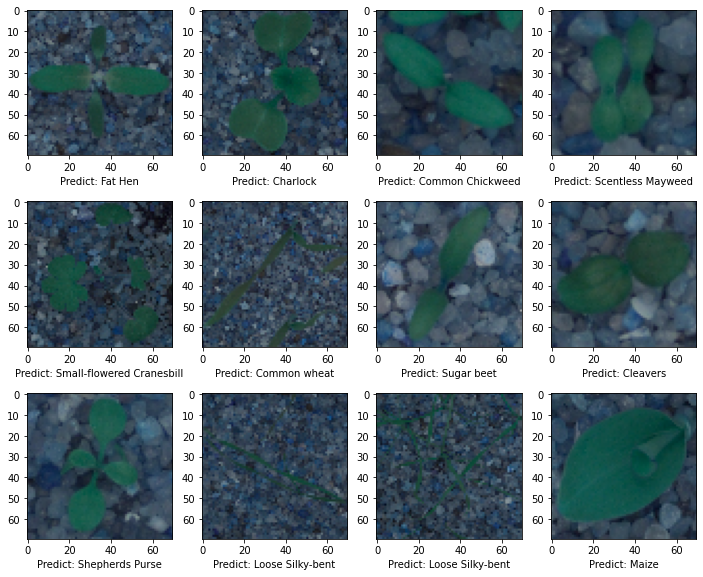

In [28]:
plt.figure(figsize=(12, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(testImg[i])
    plt.xlabel('Predict: '+predStr[i])

## 6. 可视化卷积中间层的图像

### 6.1 例化一个模型用于返回各层激活输出

In [29]:
from keras import layers, Model
 
layer_outputs = []
layer_names = []
for layer in model.layers:
    #if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    if isinstance(layer, layers.Conv2D): 
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = Model(inputs=model.input, outputs=layer_outputs)
print('There are totally {} layers in this model'.format(len(layer_names)))

There are totally 6 layers in this model


第一个卷积层输出的几个通道的数据的显示效果

In [30]:
imgName = 'D:/Jupyter Notebook/plant-seedlings-classification/train/Black-grass/0ace21089.png'
clearTestImg = []
testImg = []
testImg.append(cv2.resize(cv2.imread(imgName), (70, 70)))
testImg = np.asarray(testImg)

blurImg = cv2.GaussianBlur(testImg[0], (5, 5), 0)
hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)

lower_green = (25, 40, 50)
upper_green = (75, 255, 255)
mask = cv2.inRange(hsvImg, lower_green, upper_green)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

bMask = mask > 0

clear = np.zeros_like(testImg[0], np.uint8)
clear[bMask] = testImg[0][bMask]
clearTestImg.append(clear)
clearTestImg = np.asarray(clearTestImg)
clearTestImg = clearTestImg / 255

1/1 [==============================] - 0s 364ms/step


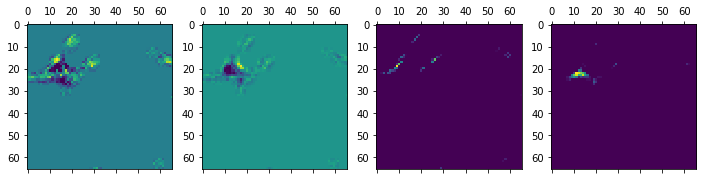

In [31]:
activations  = activation_model.predict(clearTestImg)
first_layer_activation = activations[0]

fig, ax = plt.subplots(1,4,figsize=(12,16))
ax[0].matshow(first_layer_activation[0, :, :, 0], cmap="viridis")
ax[1].matshow(first_layer_activation[0, :, :, 5], cmap="viridis")
ax[2].matshow(first_layer_activation[0, :, :, 11], cmap="viridis")
ax[3].matshow(first_layer_activation[0, :, :, 24], cmap="viridis")

### 6.2 各层各通道汇总可视化

以下代码将所有各层的各个通道的输出均以二维图像的方式汇总画出

conv2d
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_5


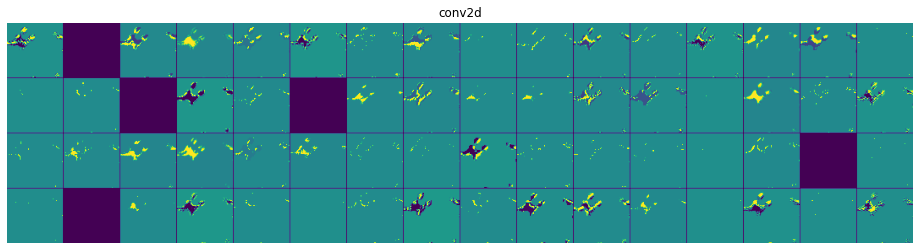

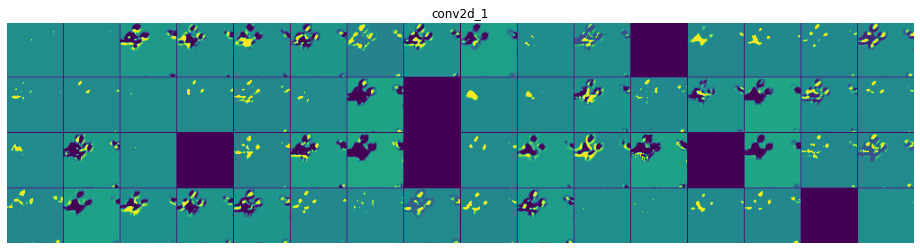

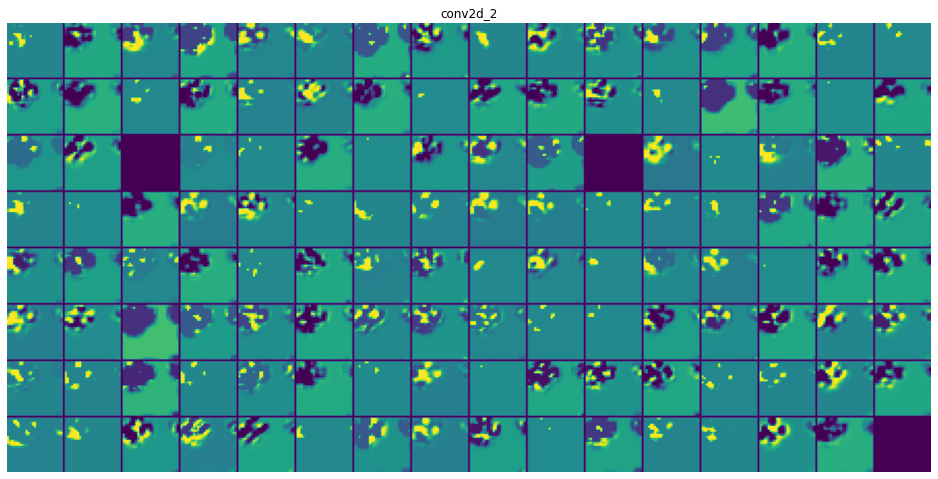

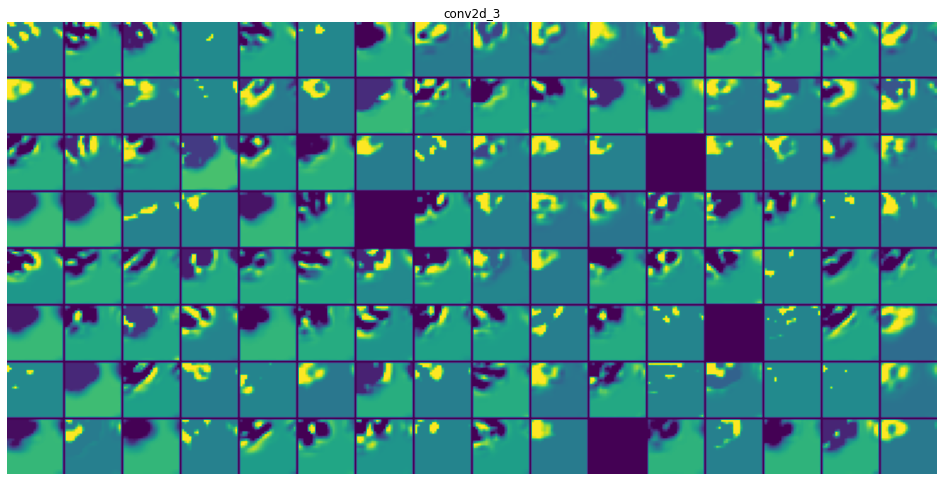

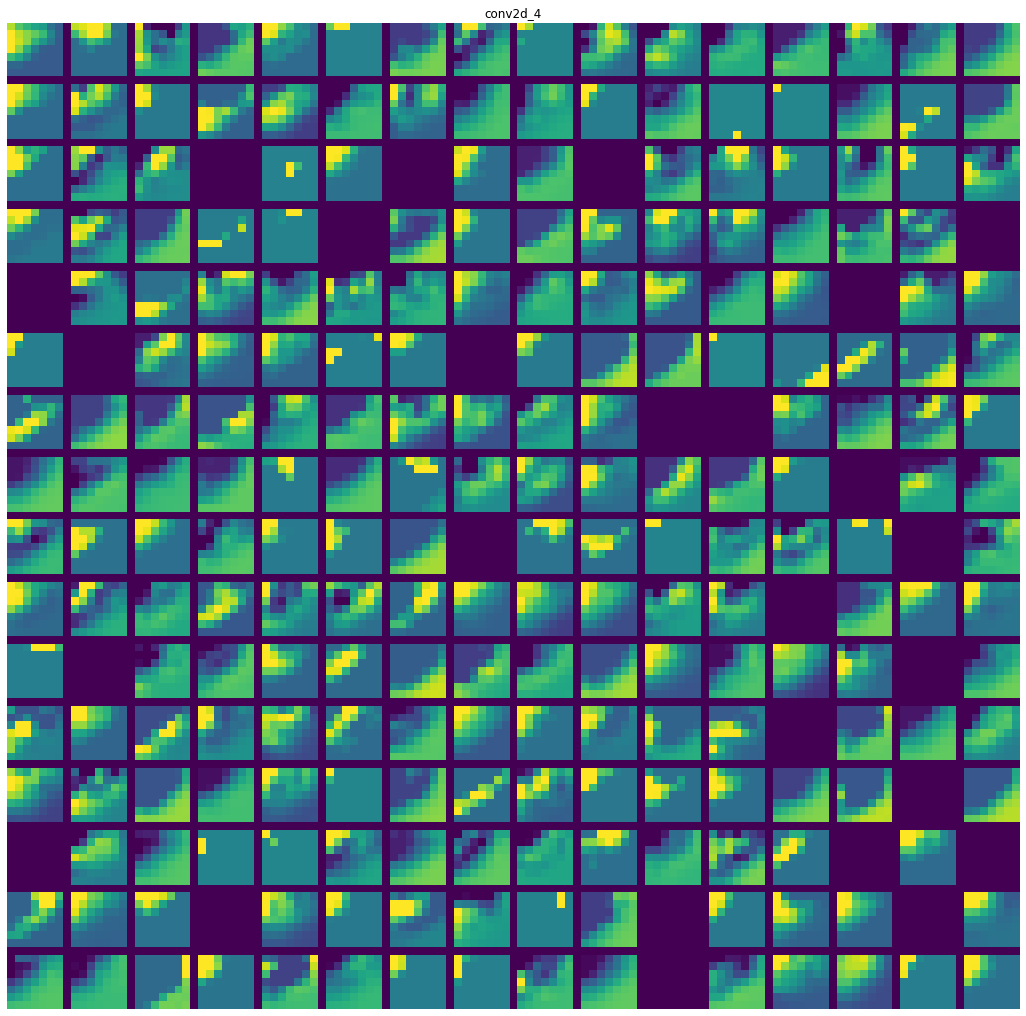

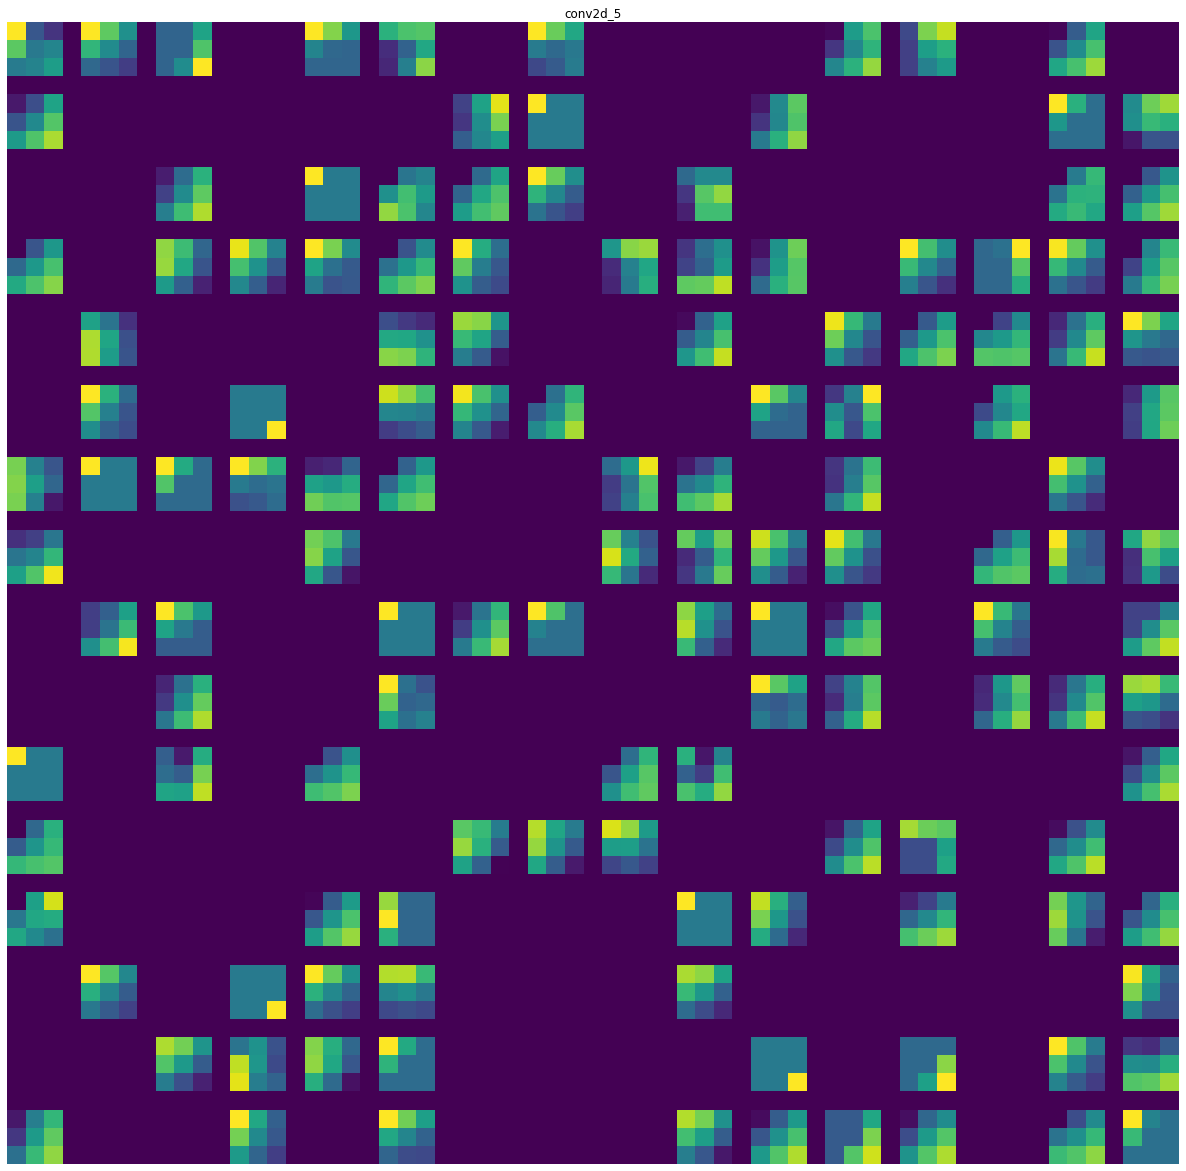

In [32]:
images_per_row = 16 # 每行16个小图
for layer_name, layer_activation in zip(layer_names, activations):
    print(layer_name)    
    n_features = layer_activation.shape[-1] # Number of features, i.e, channels of the current layer output.
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row   # n_cols should be 'number of plots per column', i.e, number of rows.
    display_grid = np.zeros(((size + 1) * n_cols - 1,images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0: #数据处理，使其适合于作为图像展示
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

## 7. PyQt实现的图形化界面

可以实现选择一张图片加载进来并预测文件夹中的每一张图  

界面截图:

![截图1](./%E5%9B%BE%E5%BD%A2%E5%8C%96%E7%95%8C%E9%9D%A2%E6%88%AA%E5%9B%BE/%E5%9B%BE%E5%BD%A2%E5%8C%96%E7%95%8C%E9%9D%A21.jpg)

![截图2](./%E5%9B%BE%E5%BD%A2%E5%8C%96%E7%95%8C%E9%9D%A2%E6%88%AA%E5%9B%BE/%E5%9B%BE%E5%BD%A2%E5%8C%96%E7%95%8C%E9%9D%A22.jpg)

![截图3](./%E5%9B%BE%E5%BD%A2%E5%8C%96%E7%95%8C%E9%9D%A2%E6%88%AA%E5%9B%BE/%E5%9B%BE%E5%BD%A2%E5%8C%96%E7%95%8C%E9%9D%A23.jpg)